## Import modules

In [63]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path
%matplotlib inline
def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims

## Specify experiment directory

In [64]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Fixed Culture/STEDBIN/'
protein="TNR" #TNR,Agg,WFA,HABP

## Make results dict and load aligned images from matlab GUI

In [65]:
#make synapse results dictionary

spots={"filename":[]}

path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    #if "_analyse" in str(filelist[i]):        
        if ("samecellonly" in str(filelist[i]))==False:
            if ("output_classification" in str(filelist[i]))==True:
                if (protein in str(filelist[i]))==True:
                    if filelist[i].endswith(".txt"): 
                        #if str(filelist[i][:-12]) not in str(spots["filename"]):
                            spots["filename"].append(filelist[i])


synapses_results={"spots classification filename":[],
                "sted spot":[],
                "vglut spot":[],
                "dio spot":[],
                "sted spot aligned":[],
                "vglut spot aligned":[],
                "dio spot aligned":[],
                 "sted spot aligned no back":[],
                "vglut spot aligned no back":[],
                "dio spot aligned no back":[],
                "Exp name":[],
                "Cell number":[],
                "unique id (expname_cell number)":[],
                "classification":[],
                  "mean ecm intensity sted":[],
                  "ecm intensity sted, bg subtracted":[],
                  "mean ecm intensity sted noback":[],
                  "ecm intensity sted noback bg subtracted":[],
                  "mean vglut intensity sted":[],
                  "vglut intensity sted, bg subtracted":[],
                  "mean vglut intensity sted noback":[],
                  "vglut intensity sted noback bg subtracted":[],
                  "mean vglut size (sum of pixels)":[],
                  "mean vglut size (sum of pixels) from noback":[],
                  "exp condition":[]}
                  
for spot in range(0,len(spots["filename"])):
    firstpart='/'.join(spots["filename"][spot].split("/")[:-1])
    lastpart=spots["filename"][spot].split("classification")[-1]
    synapses_results["spots classification filename"].append(spots["filename"][spot])
    file2read=firstpart+'/output_sted_'+lastpart
    synapses_results["sted spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_'+lastpart
    synapses_results["vglut spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_'+lastpart
    synapses_results["dio spot"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_sted_aligned_'+lastpart
    synapses_results["sted spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_aligned_'+lastpart
    synapses_results["vglut spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_aligned_'+lastpart
    synapses_results["dio spot aligned"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_sted_aligned_noback_'+lastpart
    synapses_results["sted spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_homer_aligned_noback_'+lastpart
    synapses_results["vglut spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    file2read=firstpart+'/output_dio_aligned_noback_'+lastpart
    synapses_results["dio spot aligned no back"].append(np.asarray(np.loadtxt(file2read,delimiter=',')))
    
    synapses_results["Exp name"].append(file2read.split("2019")[-1][0:4])
    synapses_results["Cell number"].append(lastpart[-9:-4])
    synapses_results["unique id (expname_cell number)"].append(file2read.split("2019")[-1][0:4]+'_'+lastpart[-9:-4])
    synapses_results["classification"].append(np.loadtxt(spots["filename"][spot]))
    synapses_results["exp condition"].append(synapses_results["spots classification filename"][spot].split("TIFs")[-1].split('/')[1])
    
    synapses_results["mean ecm intensity sted"].append(np.nan)
    synapses_results["ecm intensity sted, bg subtracted"].append(np.nan)
    synapses_results["mean ecm intensity sted noback"].append(np.nan)
    synapses_results["ecm intensity sted noback bg subtracted"].append(np.nan)
    synapses_results["mean vglut intensity sted"].append(np.nan)
    synapses_results["vglut intensity sted, bg subtracted"].append(np.nan)
    synapses_results["mean vglut intensity sted noback"].append(np.nan)
    synapses_results["vglut intensity sted noback bg subtracted"].append(np.nan)
    synapses_results["mean vglut size (sum of pixels)"].append(np.nan)
    synapses_results["mean vglut size (sum of pixels) from noback"].append(np.nan)

In [66]:
len(synapses_results["spots classification filename"])

1309

## Spot analysis

In [67]:
for spotno in range(0,len(synapses_results["spots classification filename"])):
    synapses_results["mean ecm intensity sted"][spotno]=np.nanmean(synapses_results["sted spot aligned"][spotno])
    synapses_results["mean ecm intensity sted noback"][spotno]=np.nanmean(synapses_results["sted spot aligned no back"][spotno])
    synapses_results["mean vglut intensity sted"][spotno]=np.nanmean(synapses_results["vglut spot aligned"][spotno])
    synapses_results["mean vglut intensity sted noback"][spotno]=np.nanmean(synapses_results["vglut spot aligned no back"][spotno])
    synapses_results["mean vglut size (sum of pixels)"][spotno]=np.sum(synapses_results["vglut spot aligned"][spotno])
    synapses_results["mean vglut size (sum of pixels) from noback"][spotno]=np.sum(synapses_results["vglut spot aligned no back"][spotno])

    #bg subtraction
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["sted spot aligned"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["ecm intensity sted, bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["sted spot aligned no back"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["ecm intensity sted noback bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["vglut spot aligned"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["vglut intensity sted, bg subtracted"][spotno]=(ecm_around_spot_bgsub)
    
    ecm_around_spot_bgsub=np.array(deepcopy(synapses_results["vglut spot aligned no back"][spotno]))
    bg_ecm=np.mean(ndi.median_filter(ecm_around_spot_bgsub,size=5))+0*np.std(ndi.median_filter(ecm_around_spot_bgsub,size=5))
    ecm_around_spot_bgsub=np.subtract(ecm_around_spot_bgsub,bg_ecm)
    ecm_around_spot_bgsub[ecm_around_spot_bgsub<0]=0
    synapses_results["vglut intensity sted noback bg subtracted"][spotno]=(ecm_around_spot_bgsub)

## Make average images

In [68]:
df=pd.DataFrame(synapses_results)

## Plot a random spot image

Text(0.5, 1.0, 'dio around synapse spot')

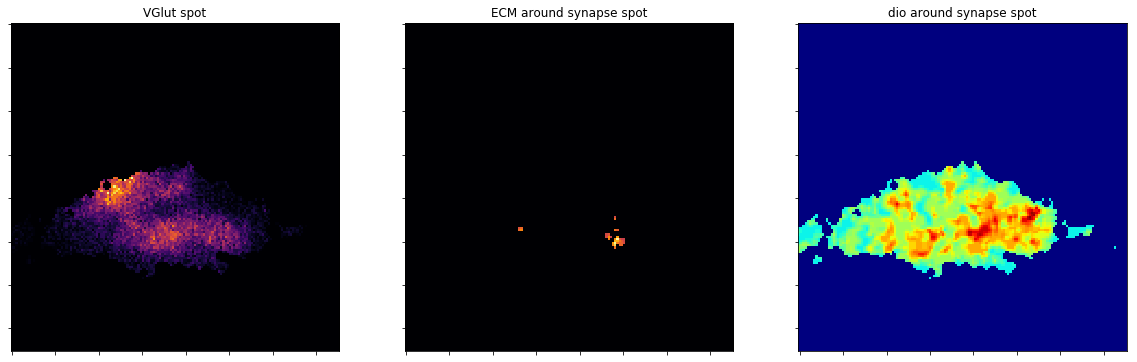

In [69]:
randomno=np.random.randint(1,len(df))
fig=plt.figure(figsize=(20,20))
fig.add_subplot(131)
plt.imshow(df["vglut spot aligned"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('VGlut spot')
fig.add_subplot(132)
plt.imshow(df["sted spot aligned"][randomno],cmap='inferno')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('ECM around synapse spot')
fig.add_subplot(133)
plt.imshow(df["dio spot aligned"][randomno],cmap='jet')
plt.xticks(visible=False)
plt.yticks(visible=False)
plt.gca().set(aspect='equal',adjustable='box')
plt.grid(False)
plt.title('dio around synapse spot')

### Add radial average

### Add meaningful columns to the df

In [70]:
#make df, which also contains column names for plotting (drug, condition)
df['Time']='None'
df.loc[df["spots classification filename"].str.contains('12hr'), 'Time'] = '12hrs'
df.loc[df['spots classification filename'].str.contains('Ctrl'), 'Time'] = 'Unblocked Control'
df.loc[df['spots classification filename'].str.contains('Unblocked'), 'Time'] = 'Unblocked Control'

df.loc[df['spots classification filename'].str.contains('Bic'), 'Drug'] = 'Bic'
df.loc[df['spots classification filename'].str.contains('DMSO'), 'Drug'] = 'DMSO'
df.loc[df['spots classification filename'].str.contains('Ctrl'), 'Drug'] = 'DMSO'
df.loc[df['spots classification filename'].str.contains('Unblocked'), 'Drug'] = 'DMSO'

#nicely written treatment condition for plotting
df['Condition']='None'
df.loc[df['spots classification filename'].str.contains('12hrs_Bic'), 'Condition'] = '12hr + Bic'
df.loc[df['spots classification filename'].str.contains('12hrs_DMSO'), 'Condition'] = '12hr + DMSO'
df.loc[df['spots classification filename'].str.contains('12hr_Bic'), 'Condition'] = '12hr + Bic'
df.loc[df['spots classification filename'].str.contains('12hr_DMSO'), 'Condition'] = '12hr + DMSO'
df.loc[df['spots classification filename'].str.contains('Ctrl'), 'Condition'] = 'Unblocked Control'
df.loc[df['spots classification filename'].str.contains('Unblocked'), 'Condition'] = 'Unblocked Control'

df["expname"]='None'
df.loc[df['spots classification filename'].str.contains('20190216'), 'expname'] = '20190216_TNR580_DiO_VGlut647'
df.loc[df['spots classification filename'].str.contains('20190225'), 'expname'] = '20190225_TNR647_VGlut580_DiO'
df.loc[df['spots classification filename'].str.contains('20190302'), 'expname'] = '20190302_TNR647_Vglut580_DiO'
df.loc[df['spots classification filename'].str.contains('20190307'), 'expname'] = '20190307_TNR647_VGlut580_DiO_analyse'

df["Type"]='None'
df.loc[df["classification"]==1,"Type"]="Mushroom"
df.loc[df["classification"]==2,"Type"]="Flat"
df.loc[df["classification"]==3,"Type"]="Bouton"

df["Epitopes and drug"]='None'
df.loc[df["Condition"]=="Unblocked Control","Epitopes"]="All (unblocked)"
df.loc[df["Condition"]=="12hr + Bic","Epitopes"]="New + bic"
df.loc[df["Condition"]=="12hr + DMSO","Epitopes"]="New + dmso"

df["Epitopes old/new"]='None'
df.loc[df["Condition"]=="Unblocked Control","Epitopes old/new"]="All (unblocked)"
df.loc[df["Condition"]=="12hr + Bic","Epitopes old/new"]="New (any drug)"
df.loc[df["Condition"]=="12hr + DMSO","Epitopes old/new"]="New (any drug)"

## Add mean intensity

In [71]:
df["mean ecm intensity sted, bg subtracted"]=np.nan
df["mean vglut intensity sted, bg subtracted"]=np.nan
for i in range(0,len(df)):
    df["mean ecm intensity sted, bg subtracted"][i]=df["ecm intensity sted, bg subtracted"][i].mean()
    df["mean vglut intensity sted, bg subtracted"][i]=df["vglut intensity sted, bg subtracted"][i].mean()

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [72]:
df2=deepcopy(df)
df2=df2.reset_index()
df2["ecm mean int norm2med"]=df2["mean ecm intensity sted, bg subtracted"]
df2["vglut mean int norm2med"]=df2["mean vglut intensity sted, bg subtracted"]

## Add mean intensities normalized by experiment median

In [73]:
expnam=[]
medtnr=[]
medvglut=[]
for exp in df2["expname"].unique():
    dfexp=df2[df2["expname"]==exp]
    med_tnr=dfexp["mean ecm intensity sted, bg subtracted"].median()
    med_vglut=dfexp["mean vglut intensity sted, bg subtracted"].median()
    print(exp+' - med tnr: '+str(med_tnr)+' - med vglut: '+str(med_vglut))
    expnam.append(exp)
    medtnr.append(med_tnr)
    medvglut.append(med_vglut)
df2["ecm mean int norm2med"]=np.nan
df2["vglut mean int norm2med"]=np.nan
df2["ecm int norm2med"]=df2["ecm intensity sted, bg subtracted"]
df2["vglut int norm2med"]=df2["vglut intensity sted, bg subtracted"]
for i in range(0,len(df2)):
    if df2["expname"][i]==expnam[0]:
        df2["ecm mean int norm2med"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/medtnr[0]
        df2["vglut mean int norm2med"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/medvglut[0]
        df2["ecm int norm2med"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],medtnr[0])
        df2["vglut int norm2med"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],medvglut[0])
    if df2["expname"][i]==expnam[1]:
        df2["ecm mean int norm2med"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/medtnr[1]
        df2["vglut mean int norm2med"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/medvglut[1]
        df2["ecm int norm2med"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],medtnr[1])
        df2["vglut int norm2med"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],medvglut[1])
    if df2["expname"][i]==expnam[2]:
        df2["ecm mean int norm2med"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/medtnr[2]
        df2["vglut mean int norm2med"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/medvglut[2]
        df2["ecm int norm2med"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],medtnr[2])
        df2["vglut int norm2med"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],medvglut[2])
    if df2["expname"][i]==expnam[3]:
        df2["ecm mean int norm2med"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/medtnr[3]
        df2["vglut mean int norm2med"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/medvglut[3]
        df2["ecm int norm2med"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],medtnr[3])
        df2["vglut int norm2med"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],medvglut[3])
 

20190216_TNR580_DiO_VGlut647 - med tnr: 0.008326720209740911 - med vglut: 1.283467670034585
20190225_TNR647_VGlut580_DiO - med tnr: 0.1399150434401048 - med vglut: 1.4925792386006091
20190302_TNR647_Vglut580_DiO - med tnr: 0.10656957898474285 - med vglut: 0.6253217099582644
20190307_TNR647_VGlut580_DiO_analyse - med tnr: 0.22731985791870396 - med vglut: 0.5239549056100902


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning

## Add mean intensities normalized by experiment unblocked control

In [74]:
expnam=[]
unblockedtnr=[]
unblockedvglut=[]
for exp in df2["expname"].unique():
    dfexp=df2[df2["expname"]==exp]
    ub_tnr=dfexp[dfexp["Condition"]=="Unblocked Control"]["mean ecm intensity sted, bg subtracted"].mean()
    ub_vglut=dfexp[dfexp["Condition"]=="Unblocked Control"]["mean vglut intensity sted, bg subtracted"].mean()
    print(exp+' - ub tnr: '+str(ub_tnr)+' - ub vglut: '+str(ub_vglut))
    expnam.append(exp)
    unblockedtnr.append(ub_tnr)
    unblockedvglut.append(ub_vglut)
df2["ecm mean int norm2unblocked"]=np.nan
df2["vglut mean int norm2unblocked"]=np.nan
df2["ecm int norm2unblocked"]=df2["ecm intensity sted, bg subtracted"]
df2["vglut int norm2unblocked"]=df2["vglut intensity sted, bg subtracted"]
for i in range(0,len(df2)):
    if df2["expname"][i]==expnam[0]:
        df2["ecm mean int norm2unblocked"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/unblockedtnr[0]
        df2["vglut mean int norm2unblocked"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/unblockedvglut[0]
        df2["ecm int norm2unblocked"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],unblockedtnr[0])
        df2["vglut int norm2unblocked"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],unblockedvglut[0])
    if df2["expname"][i]==expnam[1]:
        df2["ecm mean int norm2unblocked"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/unblockedtnr[1]
        df2["vglut mean int norm2unblocked"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/unblockedvglut[1]
        df2["ecm int norm2unblocked"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],unblockedtnr[1])
        df2["vglut int norm2unblocked"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],unblockedvglut[1])
    if df2["expname"][i]==expnam[2]:
        df2["ecm mean int norm2unblocked"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/unblockedtnr[2]
        df2["vglut mean int norm2unblocked"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/unblockedvglut[2]
        df2["ecm int norm2unblocked"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],unblockedtnr[2])
        df2["vglut int norm2unblocked"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],unblockedvglut[2])
    if df2["expname"][i]==expnam[3]:
        df2["ecm mean int norm2unblocked"][i]=df2["mean ecm intensity sted, bg subtracted"][i]/unblockedtnr[3]
        df2["vglut mean int norm2unblocked"][i]=df2["mean vglut intensity sted, bg subtracted"][i]/unblockedvglut[3]
        df2["ecm int norm2unblocked"][i]=np.divide(df2["ecm intensity sted, bg subtracted"][i],unblockedtnr[3])
        df2["vglut int norm2unblocked"][i]=np.divide(df2["vglut intensity sted, bg subtracted"][i],unblockedvglut[3])
 

20190216_TNR580_DiO_VGlut647 - ub tnr: 0.03504584577149519 - ub vglut: 2.2045963565937012
20190225_TNR647_VGlut580_DiO - ub tnr: 0.42454104310563023 - ub vglut: 2.1659258486801214
20190302_TNR647_Vglut580_DiO - ub tnr: 0.5405349960471376 - ub vglut: 0.7497164545477519
20190307_TNR647_VGlut580_DiO_analyse - ub tnr: 0.5481060955288468 - ub vglut: 0.6701365242021864


/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning

## Add radial averages

In [75]:
## radial_average version 2 - define function
def radial_average(image):
    import numpy as np
    import scipy
    from scipy import ndimage
    import matplotlib.pyplot as plt

    f = image
    sx, sy = f.shape
    X, Y = np.ogrid[0:sx, 0:sy]


    r = np.hypot(X - sx/2, Y - sy/2)

    rbin = (20* r/r.max()).astype(np.int) ##30 rings --> r-
    radial_mean = ndimage.mean(f, labels=rbin, index=np.arange(1, rbin.max() +1))
    return radial_mean

##add radial average
df2['radial_average_ecm']=''
df2['radial_average_ecm_bgsubtracted']=''
df2['radial_average_dio']=''
df2['radial_average_vglut']=''
df2['radial_average_vglut_bgsubtracted']=''
df2['radial_average_ecm_norm2meds']=''
df2['radial_average_vglut_norm2meds']=''
df2['radial_average_ecm_norm2unblocked']=''
df2['radial_average_vglut_norm2unblocked']=''
for i in range(0,len(df2['radial_average_ecm_bgsubtracted'])):
    df2['radial_average_ecm_bgsubtracted'][i]=radial_average(df2["ecm intensity sted, bg subtracted"][i])
    df2['radial_average_ecm'][i]=radial_average(df2["sted spot aligned"][i])
    df2['radial_average_vglut'][i]=radial_average(df2["vglut spot aligned"][i])
    df2['radial_average_vglut_bgsubtracted'][i]=radial_average(df2["vglut intensity sted, bg subtracted"][i])
    df2['radial_average_dio'][i]=radial_average(df2["dio spot aligned"][i])
    df2['radial_average_ecm_norm2meds'][i]=radial_average(df2["ecm int norm2med"][i])
    df2['radial_average_vglut_norm2meds'][i]=radial_average(df2["vglut int norm2med"][i])
    df2['radial_average_ecm_norm2unblocked'][i]=radial_average(df2["ecm int norm2unblocked"][i])
    df2['radial_average_vglut_norm2unblocked'][i]=radial_average(df2["vglut int norm2unblocked"][i])

/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:32: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/taldankovich/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning

## Look only at DMSO, separate into mushrooms and flats for further analysis

In [21]:
df2_newepitopes_dmso=df2[(df2["Condition"]!="Unblocked Control")&
                         (df2["Drug"]=="DMSO")]
df2_newepitopes_bic=df2[(df2["Condition"]!="Unblocked Control")&
                         (df2["Drug"]=="Bic")]
df2_newepitopes_all=df2[(df2["Condition"]!="Unblocked Control")]

df2_unblocked=df2[df2["Condition"]=="Unblocked Control"]

df2mushrooms_unblocked=df2_unblocked[df2_unblocked["classification"]==1.0]
df2flats_unblocked=df2_unblocked[df2_unblocked["classification"]==2.0]

df2mushrooms_newepitopes_all=df2_newepitopes_all[df2_newepitopes_all["classification"]==1.0]
df2flats_newepitopes_all=df2_newepitopes_all[df2_newepitopes_all["classification"]==2.0]

df2mushrooms_newepitopes_bic=df2_newepitopes_bic[df2_newepitopes_bic["classification"]==1.0]
df2flats_newepitopes_bic=df2_newepitopes_bic[df2_newepitopes_bic["classification"]==2.0]

df2mushrooms_newepitopes_dmso=df2_newepitopes_dmso[df2_newepitopes_dmso["classification"]==1.0]
df2flats_newepitopes_dmso=df2_newepitopes_dmso[df2_newepitopes_dmso["classification"]==2.0]

## Correlation mean ECM to vGlut int, separately for mushrooms and flats

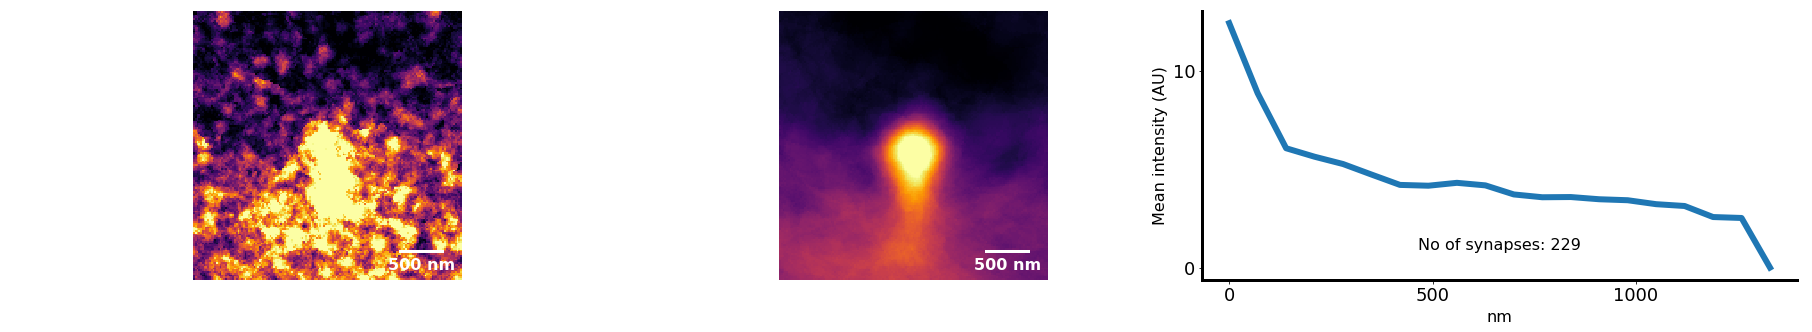

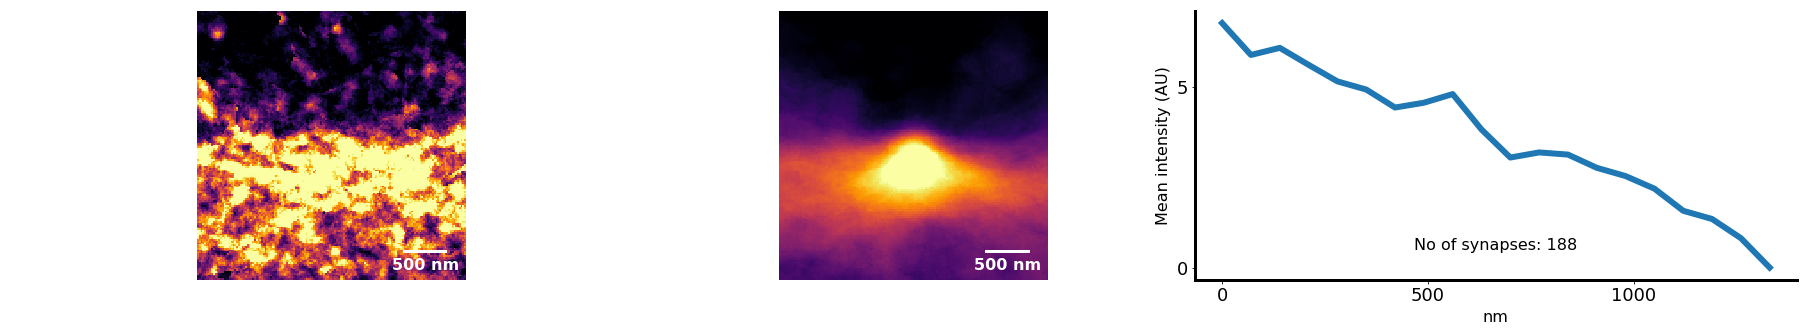

In [22]:
df22plot=df2mushrooms_unblocked
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot["sted spot aligned"].mean()
           ,cmap='inferno',
           vmin=df2["sted spot aligned"].mean().min(),
           vmax=np.max(df2["sted spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.axis('off')

fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.axis('off')



ax=fig.add_subplot(133)
plt.plot(np.linspace(0,70*20,num=20,endpoint=False),df22plot["radial_average_ecm_norm2meds"].values.mean(),linewidth=6)
numbersynapses=len(df22plot["vglut spot aligned"]) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0,0.6])
plt.xticks(size = 18)
plt.yticks(size = 18)
ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
    horizontalalignment='center',
        verticalalignment='bottom',size=16,
    transform=ax.transAxes)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
plt.xlabel('nm',size=16,labelpad=5)
#plt.subplots_adjust(right=1.2)

plt.tight_layout()

df22plot=df2flats_unblocked
fig=plt.figure(figsize=(25,5))
plt.axis('off')
#plt.title(str(i))
fig.add_subplot(131)
plt.imshow(df22plot["sted spot aligned"].mean()
           ,cmap='inferno',
           vmin=df2["sted spot aligned"].mean().min(),
           vmax=np.max(df2["sted spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.axis('off')

fig.add_subplot(132)
plt.imshow(df22plot["dio spot aligned"].mean()
           ,cmap='inferno',
           vmin=np.min(df2["dio spot aligned"].mean()),
           vmax=np.max(df2["dio spot aligned"].mean()))
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                   font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
plt.axis('off')

ax=fig.add_subplot(133)
plt.plot(np.linspace(0,70*20,num=20,endpoint=False),df22plot["radial_average_ecm_norm2meds"].values.mean(),linewidth=6)
numbersynapses=len(df22plot["vglut spot aligned"]) 
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0,0.6])
plt.xticks(size = 18)
plt.yticks(size = 18)
ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
    horizontalalignment='center',
        verticalalignment='bottom',size=16,
    transform=ax.transAxes)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
plt.xlabel('nm',size=16,labelpad=5)
#plt.subplots_adjust(right=1.2)

plt.tight_layout()

In [42]:
df22plot.columns

Index(['index', 'spots classification filename', 'sted spot', 'vglut spot',
       'dio spot', 'sted spot aligned', 'vglut spot aligned',
       'dio spot aligned', 'sted spot aligned no back',
       'vglut spot aligned no back', 'dio spot aligned no back', 'Exp name',
       'Cell number', 'unique id (expname_cell number)', 'classification',
       'mean ecm intensity sted', 'ecm intensity sted, bg subtracted',
       'mean ecm intensity sted noback',
       'ecm intensity sted noback bg subtracted', 'mean vglut intensity sted',
       'vglut intensity sted, bg subtracted',
       'mean vglut intensity sted noback',
       'vglut intensity sted noback bg subtracted',
       'mean vglut size (sum of pixels)',
       'mean vglut size (sum of pixels) from noback', 'exp condition', 'Time',
       'Drug', 'Condition', 'expname', 'Type', 'Epitopes and drug', 'Epitopes',
       'Epitopes old/new', 'mean ecm intensity sted, bg subtracted',
       'mean vglut intensity sted, bg subtracted', '

Text(0.5, 0, 'nm')

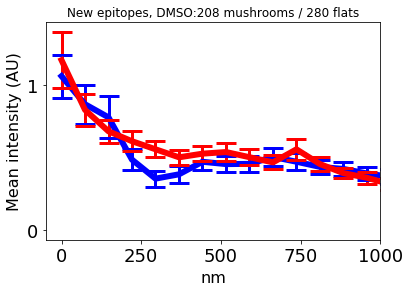

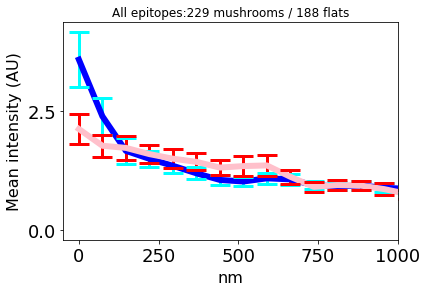

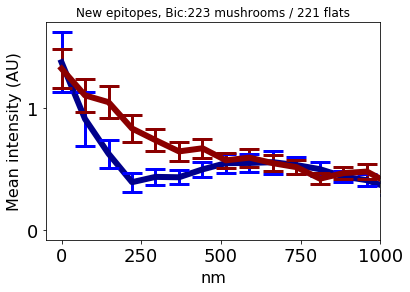

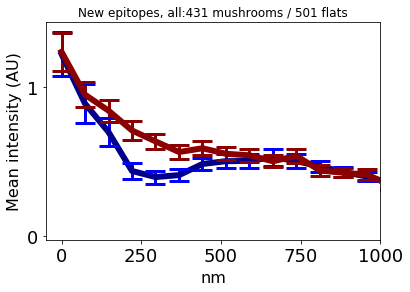

In [48]:
df22plot=df2mushrooms_newepitopes_dmso

#df22plot=df22plot[df22plot["Exp name"]==df22plot["Exp name"].unique()[1]]
plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_norm2unblocked"].values.mean(),linewidth=6,
        color='blue')
numbersynapses=len(df22plot["vglut spot aligned"])



plt.errorbar(x=np.linspace(0,70*20,num=20),
             y=df22plot["radial_average_ecm_norm2unblocked"].values.mean(),
             yerr=df22plot["radial_average_ecm_norm2unblocked"].values.std()/np.sqrt(len(df22plot)),
             xerr=None,ecolor='blue',fmt='none',capsize=10,linewidth=3,capthick=3)


df22plot=df2flats_newepitopes_dmso
#df22plot=df22plot[df22plot["Exp name"]==df22plot["Exp name"].unique()[1]]


plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_norm2unblocked"].values.mean(),linewidth=6,
        color='red')
numbersynapsesi=len(df22plot["vglut spot aligned"]) 
plt.title('New epitopes, DMSO:'+str(numbersynapses)+' mushrooms / '+str(numbersynapsesi)+ ' flats')

plt.errorbar(x=np.linspace(0,70*20,num=20),
             y=df22plot["radial_average_ecm_norm2unblocked"].values.mean(),
             yerr=df22plot["radial_average_ecm_norm2unblocked"].values.std()/np.sqrt(len(df22plot)),
             xerr=None,ecolor='red',fmt='none',capsize=10,linewidth=3,capthick=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0,0.5])
plt.xlim([-50,1000])
plt.xticks(size = 18)
plt.yticks(size = 18)
ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
    horizontalalignment='center',
        verticalalignment='bottom',size=16,
    transform=ax.transAxes)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
plt.xlabel('nm',size=16,labelpad=5)

plt.figure()

df22plot=df2mushrooms_unblocked
#df22plot=df22plot[df22plot["Exp name"]==df22plot["Exp name"].unique()[1]]


plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_norm2unblocked"].values.mean(),linewidth=6,
        color='blue')
numbersynapses=len(df22plot["vglut spot aligned"]) 


plt.errorbar(x=np.linspace(0,70*20,num=20),
             y=df22plot["radial_average_ecm_norm2unblocked"].values.mean(),
             yerr=df22plot["radial_average_ecm_norm2unblocked"].values.std()/np.sqrt(len(df22plot)),
             xerr=None,ecolor='cyan',fmt='none',capsize=10,linewidth=3,capthick=3)


df22plot=df2flats_unblocked
#df22plot=df22plot[df22plot["Exp name"]==df22plot["Exp name"].unique()[1]]


plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_norm2unblocked"].values.mean(),linewidth=6,
        color='pink')
numbersynapsesi=len(df22plot["vglut spot aligned"]) 
plt.title('All epitopes:'+str(numbersynapses)+' mushrooms / '+str(numbersynapsesi)+ ' flats')

plt.errorbar(x=np.linspace(0,70*20,num=20),
             y=df22plot["radial_average_ecm_norm2unblocked"].values.mean(),
             yerr=df22plot["radial_average_ecm_norm2unblocked"].values.std()/np.sqrt(len(df22plot)),
             xerr=None,ecolor='red',fmt='none',capsize=10,linewidth=3,capthick=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0,0.5])
plt.xlim([-50,1000])
plt.xticks(size = 18)
plt.yticks(size = 18)
ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
    horizontalalignment='center',
        verticalalignment='bottom',size=16,
    transform=ax.transAxes)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
plt.xlabel('nm',size=16,labelpad=5)

plt.figure()
df22plot=df2mushrooms_newepitopes_bic
#df22plot=df22plot[df22plot["Exp name"]==df22plot["Exp name"].unique()[1]]


plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_norm2unblocked"].values.mean(),linewidth=6,
        color='darkblue')
numbersynapses=len(df22plot["vglut spot aligned"]) 


plt.errorbar(x=np.linspace(0,70*20,num=20),
             y=df22plot["radial_average_ecm_norm2unblocked"].values.mean(),
             yerr=df22plot["radial_average_ecm_norm2unblocked"].values.std()/np.sqrt(len(df22plot)),
             xerr=None,ecolor='blue',fmt='none',capsize=10,linewidth=3,capthick=3)


df22plot=df2flats_newepitopes_bic
#df22plot=df22plot[df22plot["Exp name"]==df22plot["Exp name"].unique()[1]]


plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_norm2unblocked"].values.mean(),linewidth=6,
        color='darkred')
numbersynapsesi=len(df22plot["vglut spot aligned"]) 
plt.title('New epitopes, Bic:'+str(numbersynapses)+' mushrooms / '+str(numbersynapsesi)+ ' flats')

plt.errorbar(x=np.linspace(0,70*20,num=20),
             y=df22plot["radial_average_ecm_norm2unblocked"].values.mean(),
             yerr=df22plot["radial_average_ecm_norm2unblocked"].values.std()/np.sqrt(len(df22plot)),
             xerr=None,ecolor='darkred',fmt='none',capsize=10,linewidth=3,capthick=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0,0.5])
plt.xlim([-50,1000])
plt.xticks(size = 18)
plt.yticks(size = 18)
ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
    horizontalalignment='center',
        verticalalignment='bottom',size=16,
    transform=ax.transAxes)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
plt.xlabel('nm',size=16,labelpad=5)

plt.figure()
df22plot=df2mushrooms_newepitopes_all
#df22plot=df22plot[df22plot["Exp name"]==df22plot["Exp name"].unique()[1]]


plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_norm2unblocked"].values.mean(),linewidth=6,
        color='darkblue')
numbersynapses=len(df22plot["vglut spot aligned"]) 


plt.errorbar(x=np.linspace(0,70*20,num=20),
             y=df22plot["radial_average_ecm_norm2unblocked"].values.mean(),
             yerr=df22plot["radial_average_ecm_norm2unblocked"].values.std()/np.sqrt(len(df22plot)),
             xerr=None,ecolor='blue',fmt='none',capsize=10,linewidth=3,capthick=3)


df22plot=df2flats_newepitopes_all
#df22plot=df22plot[df22plot["Exp name"]==df22plot["Exp name"].unique()[1]]


plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_norm2unblocked"].values.mean(),linewidth=6,
        color='darkred')
numbersynapsesi=len(df22plot["vglut spot aligned"]) 
plt.title('New epitopes, all:'+str(numbersynapses)+' mushrooms / '+str(numbersynapsesi)+ ' flats')

plt.errorbar(x=np.linspace(0,70*20,num=20),
             y=df22plot["radial_average_ecm_norm2unblocked"].values.mean(),
             yerr=df22plot["radial_average_ecm_norm2unblocked"].values.std()/np.sqrt(len(df22plot)),
             xerr=None,ecolor='darkred',fmt='none',capsize=10,linewidth=3,capthick=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0,0.5])
plt.xlim([-50,1000])
plt.xticks(size = 18)
plt.yticks(size = 18)
ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
    horizontalalignment='center',
        verticalalignment='bottom',size=16,
    transform=ax.transAxes)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
plt.xlabel('nm',size=16,labelpad=5)




0216
0225
0302
0307


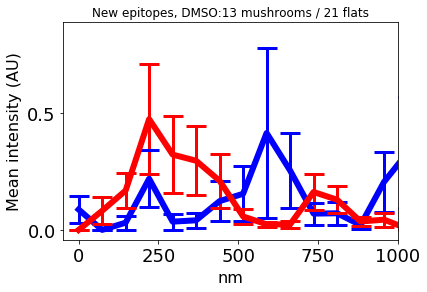

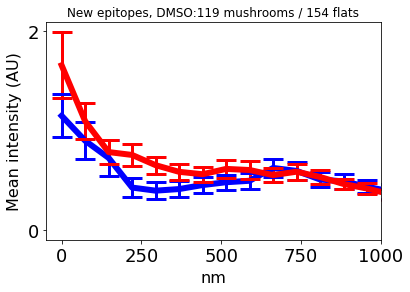

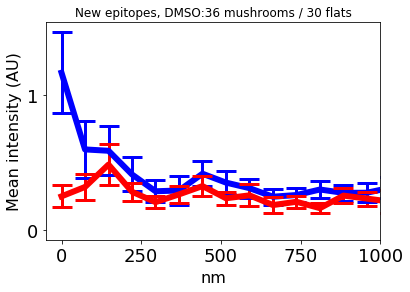

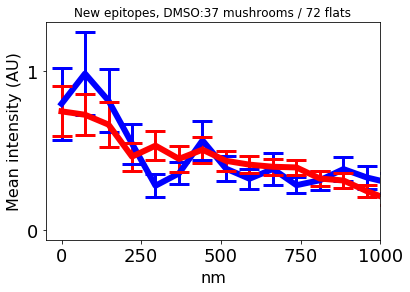

In [47]:
df2plot=df2mushrooms_newepitopes_dmso
df2plot=df2plot[df2plot["mean ecm intensity sted, bg subtracted"]<
                  df2plot["mean ecm intensity sted, bg subtracted"].quantile(0.99)]
df2plotflat=df2flats_newepitopes_dmso
df2plotflat=df2plotflat[df2plotflat["mean ecm intensity sted, bg subtracted"]<
                  df2plotflat["mean ecm intensity sted, bg subtracted"].quantile(0.99)]

for exp in df2plot["Exp name"].unique():
    plt.figure()
    print(exp)
    df22plot=df2plot[df2plot["Exp name"]==exp]
    plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_norm2unblocked"].values.mean(),linewidth=6,
            color='blue')
    numbersynapses=len(df22plot["vglut spot aligned"])

    plt.errorbar(x=np.linspace(0,70*20,num=20),
                 y=df22plot["radial_average_ecm_norm2unblocked"].values.mean(),
                 yerr=df22plot["radial_average_ecm_norm2unblocked"].values.std()/np.sqrt(len(df22plot)),
                 xerr=None,ecolor='blue',fmt='none',capsize=10,linewidth=3,capthick=3)

    df22plot=df2plotflat[df2plotflat["Exp name"]==exp]
    plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_norm2unblocked"].values.mean(),linewidth=6,
            color='red')
    numbersynapsesi=len(df22plot["vglut spot aligned"]) 
    plt.title('New epitopes, DMSO:'+str(numbersynapses)+' mushrooms / '+str(numbersynapsesi)+ ' flats')

    plt.errorbar(x=np.linspace(0,70*20,num=20),
                 y=df22plot["radial_average_ecm_norm2unblocked"].values.mean(),
                 yerr=df22plot["radial_average_ecm_norm2unblocked"].values.std()/np.sqrt(len(df22plot)),
                 xerr=None,ecolor='red',fmt='none',capsize=10,linewidth=3,capthick=3)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_linewidth(3)
    ax.spines['left'].set_linewidth(3)
    #plt.ylim([0,0.5])
    plt.xlim([-50,1000])
    plt.xticks(size = 18)
    plt.yticks(size = 18)
    ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
        horizontalalignment='center',
            verticalalignment='bottom',size=16,
        transform=ax.transAxes)
    plt.locator_params(axis='y', nbins=2)
    plt.locator_params(axis='x', nbins=5)
    plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
    plt.xlabel('nm',size=16,labelpad=5)

In [ ]:
df2.columns

Text(0.5, 0, 'nm')

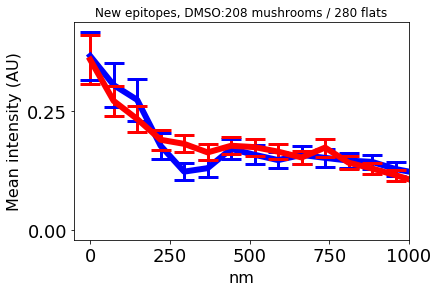

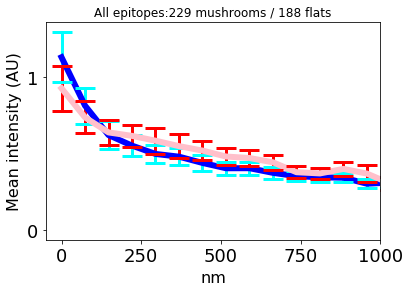

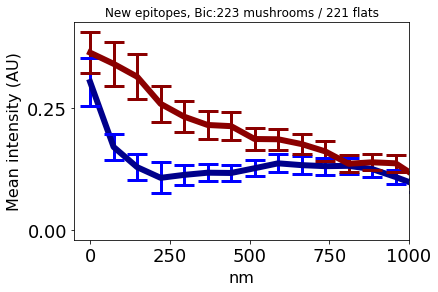

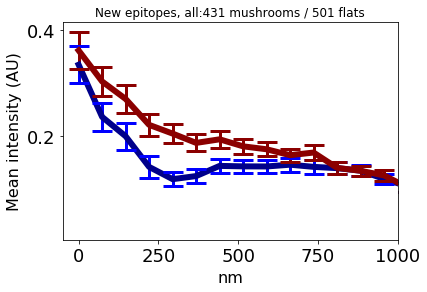

In [26]:
df22plot=df2mushrooms_newepitopes_dmso
#df22plot=df22plot[df22plot["Exp name"]==df22plot["Exp name"].unique()[2]]
plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_bgsubtracted"].values.mean(),linewidth=6,
        color='blue')
numbersynapses=len(df22plot["vglut spot aligned"])



plt.errorbar(x=np.linspace(0,70*20,num=20),
             y=df22plot["radial_average_ecm_bgsubtracted"].values.mean(),
             yerr=df22plot["radial_average_ecm_bgsubtracted"].values.std()/np.sqrt(len(df22plot)),
             xerr=None,ecolor='blue',fmt='none',capsize=10,linewidth=3,capthick=3)


df22plot=df2flats_newepitopes_dmso
#df22plot=df22plot[df22plot["Exp name"]==df22plot["Exp name"].unique()[2]]


plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_bgsubtracted"].values.mean(),linewidth=6,
        color='red')
numbersynapsesi=len(df22plot["vglut spot aligned"]) 
plt.title('New epitopes, DMSO:'+str(numbersynapses)+' mushrooms / '+str(numbersynapsesi)+ ' flats')

plt.errorbar(x=np.linspace(0,70*20,num=20),
             y=df22plot["radial_average_ecm_bgsubtracted"].values.mean(),
             yerr=df22plot["radial_average_ecm_bgsubtracted"].values.std()/np.sqrt(len(df22plot)),
             xerr=None,ecolor='red',fmt='none',capsize=10,linewidth=3,capthick=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0,0.5])
plt.xlim([-50,1000])
plt.xticks(size = 18)
plt.yticks(size = 18)
ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
    horizontalalignment='center',
        verticalalignment='bottom',size=16,
    transform=ax.transAxes)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
plt.xlabel('nm',size=16,labelpad=5)

plt.figure()

df22plot=df2mushrooms_unblocked
#df22plot=df22plot[df22plot["Exp name"]==df22plot["Exp name"].unique()[2]]


plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_bgsubtracted"].values.mean(),linewidth=6,
        color='blue')
numbersynapses=len(df22plot["vglut spot aligned"]) 


plt.errorbar(x=np.linspace(0,70*20,num=20),
             y=df22plot["radial_average_ecm_bgsubtracted"].values.mean(),
             yerr=df22plot["radial_average_ecm_bgsubtracted"].values.std()/np.sqrt(len(df22plot)),
             xerr=None,ecolor='cyan',fmt='none',capsize=10,linewidth=3,capthick=3)


df22plot=df2flats_unblocked
#df22plot=df22plot[df22plot["Exp name"]==df22plot["Exp name"].unique()[2]]


plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_bgsubtracted"].values.mean(),linewidth=6,
        color='pink')
numbersynapsesi=len(df22plot["vglut spot aligned"]) 
plt.title('All epitopes:'+str(numbersynapses)+' mushrooms / '+str(numbersynapsesi)+ ' flats')

plt.errorbar(x=np.linspace(0,70*20,num=20),
             y=df22plot["radial_average_ecm_bgsubtracted"].values.mean(),
             yerr=df22plot["radial_average_ecm_bgsubtracted"].values.std()/np.sqrt(len(df22plot)),
             xerr=None,ecolor='red',fmt='none',capsize=10,linewidth=3,capthick=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0,0.5])
plt.xlim([-50,1000])
plt.xticks(size = 18)
plt.yticks(size = 18)
ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
    horizontalalignment='center',
        verticalalignment='bottom',size=16,
    transform=ax.transAxes)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
plt.xlabel('nm',size=16,labelpad=5)

plt.figure()
df22plot=df2mushrooms_newepitopes_bic
#df22plot=df22plot[df22plot["Exp name"]==df22plot["Exp name"].unique()[2]]


plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_bgsubtracted"].values.mean(),linewidth=6,
        color='darkblue')
numbersynapses=len(df22plot["vglut spot aligned"]) 


plt.errorbar(x=np.linspace(0,70*20,num=20),
             y=df22plot["radial_average_ecm_bgsubtracted"].values.mean(),
             yerr=df22plot["radial_average_ecm_bgsubtracted"].values.std()/np.sqrt(len(df22plot)),
             xerr=None,ecolor='blue',fmt='none',capsize=10,linewidth=3,capthick=3)


df22plot=df2flats_newepitopes_bic
#df22plot=df22plot[df22plot["Exp name"]==df22plot["Exp name"].unique()[2]]


plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_bgsubtracted"].values.mean(),linewidth=6,
        color='darkred')
numbersynapsesi=len(df22plot["vglut spot aligned"]) 
plt.title('New epitopes, Bic:'+str(numbersynapses)+' mushrooms / '+str(numbersynapsesi)+ ' flats')

plt.errorbar(x=np.linspace(0,70*20,num=20),
             y=df22plot["radial_average_ecm_bgsubtracted"].values.mean(),
             yerr=df22plot["radial_average_ecm_bgsubtracted"].values.std()/np.sqrt(len(df22plot)),
             xerr=None,ecolor='darkred',fmt='none',capsize=10,linewidth=3,capthick=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0,0.5])
plt.xlim([-50,1000])
plt.xticks(size = 18)
plt.yticks(size = 18)
ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
    horizontalalignment='center',
        verticalalignment='bottom',size=16,
    transform=ax.transAxes)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
plt.xlabel('nm',size=16,labelpad=5)

plt.figure()
df22plot=df2mushrooms_newepitopes_all
#df22plot=df22plot[df22plot["Exp name"]==df22plot["Exp name"].unique()[2]]


plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_bgsubtracted"].values.mean(),linewidth=6,
        color='darkblue')
numbersynapses=len(df22plot["vglut spot aligned"]) 


plt.errorbar(x=np.linspace(0,70*20,num=20),
             y=df22plot["radial_average_ecm_bgsubtracted"].values.mean(),
             yerr=df22plot["radial_average_ecm_bgsubtracted"].values.std()/np.sqrt(len(df22plot)),
             xerr=None,ecolor='blue',fmt='none',capsize=10,linewidth=3,capthick=3)


df22plot=df2flats_newepitopes_all
#df22plot=df22plot[df22plot["Exp name"]==df22plot["Exp name"].unique()[2]]


plt.plot(np.linspace(0,70*20,num=20),df22plot["radial_average_ecm_bgsubtracted"].values.mean(),linewidth=6,
        color='darkred')
numbersynapsesi=len(df22plot["vglut spot aligned"]) 
plt.title('New epitopes, all:'+str(numbersynapses)+' mushrooms / '+str(numbersynapsesi)+ ' flats')

plt.errorbar(x=np.linspace(0,70*20,num=20),
             y=df22plot["radial_average_ecm_bgsubtracted"].values.mean(),
             yerr=df22plot["radial_average_ecm_bgsubtracted"].values.std()/np.sqrt(len(df22plot)),
             xerr=None,ecolor='darkred',fmt='none',capsize=10,linewidth=3,capthick=3)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['bottom'].set_linewidth(3)
ax.spines['left'].set_linewidth(3)
#plt.ylim([0,0.5])
plt.xlim([-50,1000])
plt.xticks(size = 18)
plt.yticks(size = 18)
ax.text(.5,.1,'No of synapses: '+str(numbersynapses),
    horizontalalignment='center',
        verticalalignment='bottom',size=16,
    transform=ax.transAxes)
plt.locator_params(axis='y', nbins=2)
plt.locator_params(axis='x', nbins=5)
plt.ylabel('Mean intensity (AU)',size=16,labelpad=5)
plt.xlabel('nm',size=16,labelpad=5)





In [33]:
df2["Epitopes old/new"]='None'
df2.loc[df2["Condition"]=="Unblocked Control","Epitopes old/new"]="All (unblocked)"
df2.loc[df2["Condition"]=="12hr + Bic","Epitopes old/new"]="New (any drug)"
df2.loc[df2["Condition"]=="12hr + DMSO","Epitopes old/new"]="New (any drug)"

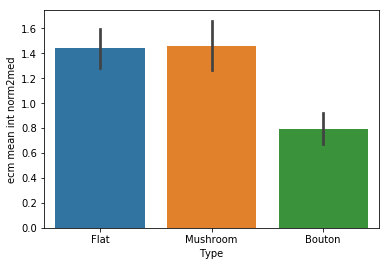

In [34]:
sns.barplot(data=df2[df2["Epitopes old/new"]=="New (any drug)"],y="ecm mean int norm2med",x="Type")